# 3.1 MNIST

In [1]:
import numpy as np
import pandas as pd

In [20]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [16]:
X, y = mnist["data"], mnist['target']
print(X.shape) # 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
print(y.shape) # 레이블 배열을 담은 target 키

(70000, 784)
(70000,)


이미지가 70000개 있고 각 이미지에는 784개의 특성이 있다. 이미지가 28*28 픽셀이기 때문이다. 개개의 특성은 0(흰색)부터 255(검은색)까지의 픽셀강도를 나타낸다

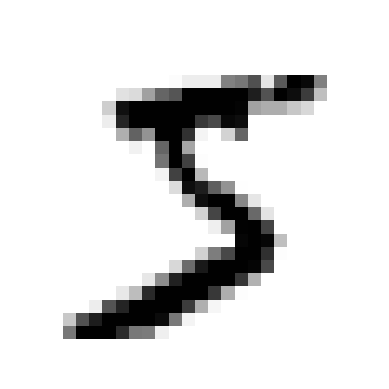

In [4]:
# 이미지 하나를 확인해보기

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].values
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
y[0]

'5'

In [ ]:
# 레이블은 문자열이다. 대부분의 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환

y = y.astype(np.uint8)

In [17]:
# y_train은 0부터 9까지

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 이진 분류기 훈련

5감지기는 5와 5아님 두 개의 클래스를 구분할 수 있는 이진분류기의 한 예이다

In [18]:
y_train_5 = (y_train == 5) # 5만 True고 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

사이킷런의 SGDClassifier 모델을 만들고 전체 훈련 세트를 사용해 훈련

In [19]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

ValueError: The number of classes has to be greater than one; got 1 class

In [ ]:
sgd_clf.predict([some_digit]) # 숫자 5의 이미지를 감지해보기

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# 3.3 성능 측정

## 3.3.1 교차검증을 사용한 정확도 측정

In [ ]:
# 가끔 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요가 있다. 아래 코드는 교차 검증 기능을 직접 구현하면 됨
# 사이킷런의 cross_val_score() 함수와 거의 같은 작업을 수행한다
'''
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # 0.9502, 0.96565, 0.96495 출력
'''

KeyError: "None of [Index([    1,     3,     4,     5,     7,     8,    10,    11,    12,    13,\n       ...\n       59984, 59985, 59987, 59988, 59989, 59991, 59993, 59994, 59996, 59998],\n      dtype='int64', length=40000)] are in the [columns]"

폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가해보니, 모든 교차검증 폴드에 대해 정확도(정확한 예측의 비율)가 95% 이상이다

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

모든 이미지를 '5아님'클래스로 분류하는 더미 분류기를 만들어 비교해보자

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

-> 이미지의 10%만 숫자 5이기 때문에 무조건 5아님으로 예측하면 정확히 맞출 확률이 90%이다.
하지만 정확도를 분류기의 성능 지표로 선호하지 않는 이유를 보여준다. 특히 불균형한 데이터셋을 다룰 때 더욱 그렇다.

## 3.3.2 오차행렬

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

-> cross_val_score()함수처럼 cross_val_predict()함수는 k-겹 교차검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환함

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

-> 687개는 거짓 양성, 1891개는 거짓 음성이다. 완벽한 분류기라면 오차행렬의 주대각선만 0이 아닌 값이 된다.

In [ ]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

-> 오차행렬이 많은 정보를 제공하지만 요약된 지표도 필요할 때가 있다. 양성 예측의 정확도인 '정밀도'와 분류기가 정확하게 감지한 양성 샘플의 비율인 '재현율'과 같이 사용하는 것이 일반적!

## 3.3.3 정밀도와 재현율

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

정밀도와 재현율을 F1 점수라고 하는 하나의 숫자로 만들면 편리할 때가 많다. F1 점수는 정밀도와 재현율의 조화 평균임

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

정밀도/재현율 트레이드오프가 나타난다. 상황에 따라 둘 중 어느 것을 중시할지 선택 ex) 어린아이에게 안전한 동영상을 걸러내는 분류기를 훈련시킨다 -> 높은 정밀도 & 낮은 재현율을 가진 분류기를 선호할 것임

## 3.3.4 정밀도/재현율 트레이드오프

임곗값을 높일수록 재현율은 낮아지고 정밀도는 높아진다

분류기의 predict() 메서드 대신 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다. 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있다

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [ ]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
threshold=8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

-> 이미지가 실제로 5이고 임곗값이 0일 때는 분류기가 이를 감지했지만, 임곗값을 8000으로 높이면 이를 놓치게 됨 (재현율이 줄어든다는 의미)

In [ ]:
# method를 다음과 같이 설정하여 예측 결과가 아니라 결정점수를 반환받도록 지정해야 함

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

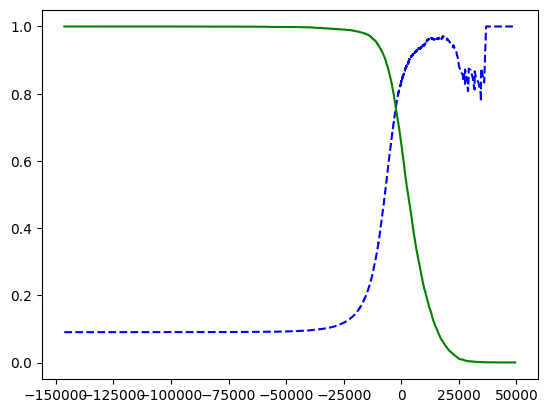

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
  plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
  [...]

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
# 정밀도가 90%가 되는 가장 낮은 임곗값을 찾을 수 있음. np.argmax()는 최댓값의 첫번째 인덱스를 반환. 여기선 첫번째 True값을 의미함

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
print(precision_score(y_train_5, y_train_pred_90))
recall_score(y_train_5, y_train_pred_90)

0.9000345901072293


0.4799852425751706

-> 정밀도가 90%를 달성한 분류기를 만들었다.

## 3.3.5 ROC곡선

- TPR = 재현율 (진짜양성비율)
- FPR = 가짜양성비율
-> ROC 곡선은 FPR에 대한 TPR의 곡선이다.  

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, threshodlds = roc_curve(y_train_5, y_scores)

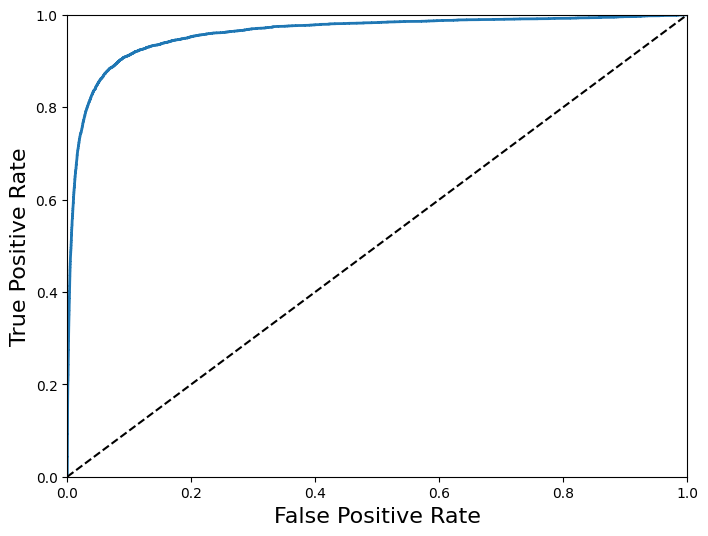

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616



---



RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC곡선과 ROX AUC 점수를 비교해보자

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5,
                                    cv=3, method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용함
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

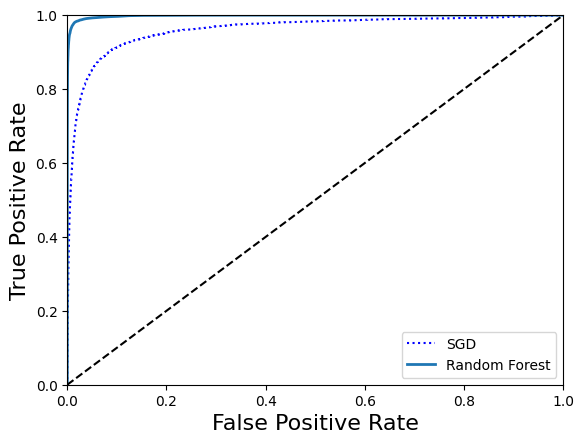

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
y_train_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [ ]:
precision_score(y_train_5, y_train_pred)

0.9905083315756169

In [ ]:
recall_score(y_train_5, y_train_pred)

0.8662608374838591

-> roc auc 점수와 재현율, 정밀도 모두 rf일 때 sgd보다 더 좋아졌다. 또한 roc 곡선만 봐도 좋다는 것을 알 수 있다

# 3.4 다중 분류

- OvR 전략: 특정 숫자 하나만 구분하는 숫자별 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법
- OvO 전략: 각 숫자의 조합마다(ex. 0과 1, 0과 2 등) 이진 분류기를 훈련시키는 것


대부분의 이진 분류 알고리즘에서는 OvR를 선호한다.(서포트 벡터 머신 같은 일부 알고리즘 제외) 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행한다.

In [7]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train_5가 아니고 y_train을 사용한다
svm_clf.predict([some_digit])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array(['5'], dtype=object)

In [8]:
# OvO 전략을 사용했는지 정말 확인하기

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

-> 샘플당 1개가 아니라 10개의 점수를 반환하는 것을 확인할 수 있음

In [9]:
np.argmax(some_digit_scores)
svm_clf.classes_
svm_clf.classes_[5]

'5'

In [10]:
# 사이킷런에서 OvO나 OvR을 사용하도록 강제하기

from sklearn.multiclass import OneVsOneClassifier
ovr_clf = OneVsOneClassifier(SVC())
ovr_clf.fit(X_train, y_train)
print(ovr_clf.predict([some_digit]))
len(ovr_clf.estimators_)

['5']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


45

In [12]:
# SGD 분류기는 직접 샘플을 다중클래스로 분류할 수 있으므로 별도로 사이킷런의 OvR이나 OvO를 적용할 필요 없음

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

NameError: name 'sgd_clf' is not defined

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

In [ ]:
# 입력 스케일을 조정하면 정확도를 89% 이상으로 높일 수 있음

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

# 3.5 에러 분석

가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법을 찾아보는 것이다. 한 가지 방법은 만들어진 에러의 종류를 분석하는 것이다.

In [ ]:
# 오차행렬 살펴보기
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
# 오차행렬을 이미지로 표현

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# 오차행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교함

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 3.6 다중 레이블 분류

분류기가 앨리스, 밥, 찰리 세 얼굴을 인식하도록 훈련되었다고 가정하자. 분류기가 앨리스와 찰리가 있는 사진을 본다면 [1,0,1]을 출력해야 할 것. 이처럼 여러개의 이진 꼬리표를 출력하는 분류 시스템을 다중 레이블 분류 시스템이라고 함

In [ ]:
from sklearn.neighbors import KNeighhborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit]) # 5는 7보다 크지않고 홀수이므로 올바르게 분류

In [ ]:
# 다중 분류기를 평가하는 방법 중 하나인 모든 레이블에 대한 F1 점수의 평균 계산하기
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

# 3.7 다중 출력 분류

이미지에서 잡음을 제거하는 시스템을 만들어보자. 잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 픽셀의 강도를 담은 배열로 출력한다.

분류기의 출력은 다중 레이블이고 (픽셀 당 한 레이블) 각 레이블은 값을 여러개 가진다 (0부터 255까지 픽셀 강도)

In [21]:
# 타깃 이미지는 원본 이미지가 될 것이다

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

ValueError: Unable to coerce to DataFrame, shape must be (10000, 784): given (60000, 784)

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)